# CASE STUDY: NYC Parking Tickets

### IMPORTING SPARKSESSION, CSV-FILE:

In [1]:
# Importing SparkSession:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("PySpark DataFrame and Sql") \
    .getOrCreate()

In [2]:
# Importing data and creating a dataframe 'df':

df = spark.read.format("csv").option("header", "true").load("/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv")
df

DataFrame[Summons Number: string, Plate ID: string, Registration State: string, Issue Date: string, Violation Code: string, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: string, Issuer Precinct: string, Violation Time: string]

### BASIC DATA INSPECTION:

In [3]:
# Checking first five rows of df:

df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|

In [4]:
# Displaying the df in proper table format for better understanding:

df.limit(5).toPandas().head()

,Summons Number,Plate ID,Registration State,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Precinct,Issuer Precinct,Violation Time
0,5092469481,GZH7067,NY,2016-07-10,7,SUBN,TOYOT,0,0,0143A
1,5092451658,GZH7067,NY,2016-07-08,7,SUBN,TOYOT,0,0,0400P
2,4006265037,FZX9232,NY,2016-08-23,5,SUBN,FORD,0,0,0233P
3,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A
4,7868300310,37033JV,NY,2016-11-21,69,DELV,INTER,13,13,0555P


In [5]:
#DataFame a schema to define the columns:

df.printSchema()

root
 |-- Summons Number: string (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: string (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: string (nullable = true)
 |-- Issuer Precinct: string (nullable = true)
 |-- Violation Time: string (nullable = true)



In [6]:
# Checking size of the dataframe (number of rows and columns respectively):

print((df.count(), len(df.columns)))

(10803028, 10)


In [7]:
# Data inspection (summary statistics):

df.describe().show()

+-------+-------------------+--------+------------------+----------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|     Summons Number|Plate ID|Registration State|Issue Date|    Violation Code| Vehicle Body Type|      Vehicle Make|Violation Precinct|  Issuer Precinct|   Violation Time|
+-------+-------------------+--------+------------------+----------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|           10803028|10803028|          10803028|  10803028|          10803028|          10803028|          10803028|          10803028|         10803028|         10803028|
|   mean|6.817447029065788E9|Infinity|              99.0|      null|34.599430455979565|3.9258887134586864| 6519.974025974026| 45.01216260848347|46.82931211508477|909.2857142857143|
| stddev|2.320233962328227E9|     NaN|               0.0|      null|19.359868716323483|0.501341

In [8]:
# Checking number of NaNs/Null per column

from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|             0|       0|                 0|         0|             0|                0|           0|                 0|              0|             0|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



##### We can see that data is clean in terms of NaN/ Null values. None of the columns have them. 

In [9]:
# Dropping duplicate rows to get a dataframe without duplicate entries:

df.select().dropDuplicates().show()

++
||
++
||
++



In [10]:
# Cross-checking the size of the dataframe after removing duplicate entries (if any) (number of rows and columns respectively):

print((df.count(), len(df.columns)))

(10803028, 10)


We can see that there were no duplicate entries in the dataframe 'df'. 

Data is now clean. We can proceed with data examination steps. 

### DATA EXAMINATION:

In [11]:
# 1) Find the total number of tickets for the year.
# Counting the number of rows in df will give us total number of tickets for the year. 

df.count()

10803028

In [12]:
# 2) Find out the number of unique states from where the cars that got parking tickets came.

from pyspark.sql.functions import col, countDistinct
df.agg(countDistinct(col("Registration State")).alias("Count of Unique States")).show()

+----------------------+
|Count of Unique States|
+----------------------+
|                    67|
+----------------------+



In [13]:
# Number of records per Registration state: Ordering the data by 'count' in descending order

df.groupBy("Registration State").count().orderBy("count",ascending=False).show()

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|8481061|
|                NJ| 925965|
|                PA| 285419|
|                FL| 144556|
|                CT| 141088|
|                MA|  85547|
|                IN|  80749|
|                VA|  72626|
|                MD|  61800|
|                NC|  55806|
|                IL|  37329|
|                GA|  36852|
|                99|  36625|
|                TX|  36516|
|                AZ|  26426|
|                OH|  25302|
|                CA|  24260|
|                SC|  21836|
|                ME|  21574|
|                MN|  18227|
+------------------+-------+
only showing top 20 rows



From above table, we can see a numeric entry '99' in column 'Registration state. This needs to be corrected with state having maximum entries. Since the data is ordered in descending order, we can see that 'NY' is the state with maximum entries (total NY entries = 8481061). 
Hence, we will replace '99' with 'NY'. 

In [14]:
# Replacing '99' with 'NY' and creating a new dataframe df1:

df1 = df.replace('99','NY')

# Checking the number of entries for 'NY' after replacement:

df1.groupBy("Registration State").count().orderBy("count",ascending=False).show()

+------------------+-------+
|Registration State|  count|
+------------------+-------+
|                NY|8517686|
|                NJ| 925965|
|                PA| 285419|
|                FL| 144556|
|                CT| 141088|
|                MA|  85547|
|                IN|  80749|
|                VA|  72626|
|                MD|  61800|
|                NC|  55806|
|                IL|  37329|
|                GA|  36852|
|                TX|  36516|
|                AZ|  26426|
|                OH|  25302|
|                CA|  24260|
|                SC|  21836|
|                ME|  21574|
|                MN|  18227|
|                OK|  18165|
+------------------+-------+
only showing top 20 rows



In [15]:
# The number of unique states again after replacing '99' with 'NY':

df1.agg(countDistinct(col("Registration State")).alias("Count of Unique Registration_States_replace")).show()

+-------------------------------------------+
|Count of Unique Registration_States_replace|
+-------------------------------------------+
|                                         66|
+-------------------------------------------+



### AGGREGATION TASKS:

#### Q.1) How often does each violation code occur? Display the frequency of the top five violation codes.

In [16]:
# The number of unique Violation Codes:

df1.agg(countDistinct(col("Violation Code")).alias("Count of Unique Violation_Code")).show()

+------------------------------+
|Count of Unique Violation_Code|
+------------------------------+
|                           100|
+------------------------------+



In [17]:
# 1) How often does each violation code occur? 
# (By using show(100), we can get the frequency of occurance of each Violation Code)

df1.groupBy("Violation Code").count().orderBy("count",ascending=False).show(100)

+--------------+-------+
|Violation Code|  count|
+--------------+-------+
|            21|1528588|
|            36|1400614|
|            38|1062304|
|            14| 893498|
|            20| 618593|
|            46| 600012|
|            37| 596769|
|            71| 521308|
|            40| 519615|
|             7| 516395|
|            19| 290920|
|            70| 273887|
|            69| 183509|
|            16| 160448|
|            31| 146680|
|             5| 145655|
|            47| 113927|
|            74| 112669|
|            50| 100115|
|            48|  83550|
|            17|  74916|
|            84|  71608|
|            24|  70168|
|            42|  64918|
|            51|  61389|
|            78|  56744|
|             9|  56633|
|            98|  51011|
|            10|  46759|
|            68|  42944|
|            53|  35323|
|            82|  33404|
|            66|  25896|
|            13|  21109|
|            85|  19502|
|            18|  18362|
|            45|  16260|


In [18]:
# Display the frequency of the top five violation codes:

df1.groupBy("Violation Code").count().orderBy("count",ascending=False).show(5)

+--------------+-------+
|Violation Code|  count|
+--------------+-------+
|            21|1528588|
|            36|1400614|
|            38|1062304|
|            14| 893498|
|            20| 618593|
+--------------+-------+
only showing top 5 rows



##### Top 5 Violation codes are: 21, 36, 38, 14, and 20.

#### Q.2) How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'?

In [19]:
# 2) How often does each 'vehicle body type' get a parking ticket? Display top 5 entries.

df1.groupBy("Vehicle Body Type").count().orderBy("count",ascending=False).show(5)

+-----------------+-------+
|Vehicle Body Type|  count|
+-----------------+-------+
|             SUBN|3719802|
|             4DSD|3082020|
|              VAN|1411970|
|             DELV| 687330|
|              SDN| 438191|
+-----------------+-------+
only showing top 5 rows



##### Top 5 'Vehicle Body Type' which get tickets are: SUBN (suburban), 4DSD(four-door sedan ) , VAN, DELV(delivery) and SDN( sedan). 

In [20]:
# How often does each 'vehicle make' get a parking ticket? Display top 5 entries.

df1.groupBy("Vehicle Make").count().orderBy("count",ascending=False).show(5)

+------------+-------+
|Vehicle Make|  count|
+------------+-------+
|        FORD|1280958|
|       TOYOT|1211451|
|       HONDA|1079238|
|       NISSA| 918590|
|       CHEVR| 714655|
+------------+-------+
only showing top 5 rows



##### Top 5 'Vehicle Make' which get tickets are: FORD, TOYOTA, HONDA, NISSAN and CHEVROLET.

#### Q.3) A precinct is a police station that has a certain zone of the city under its command. Find the (5 highest) frequencies of tickets for each of the following:
'Violation Precinct' (This is the precinct of the zone where the violation occurred). Using this, can you draw any insights for parking violations in any specific areas of the city?
'Issuer Precinct' (This is the precinct that issued the ticket.)
Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts.

In [21]:
# 3) 1) 'Violation Precinct' (This is the precinct of the zone where the violation occurred). 

df1.groupBy("Violation Precinct").count().orderBy("count",ascending=False).show()

+------------------+-------+
|Violation Precinct|  count|
+------------------+-------+
|                 0|2072400|
|                19| 535671|
|                14| 352450|
|                 1| 331810|
|                18| 306920|
|               114| 296514|
|                13| 246595|
|               109| 218141|
|                17| 193024|
|                70| 192831|
|               115| 174332|
|                84| 171079|
|                61| 166997|
|                20| 163992|
|               108| 159276|
|                52| 152046|
|                66| 150370|
|               112| 148314|
|               103| 144607|
|                90| 143443|
+------------------+-------+
only showing top 20 rows



In [22]:
# Since first entry '0' is an erroneous entry (as per the problem statement), we will ignore this.
# To get top five entries, we will get top six and ignore first entry. 

df1.groupBy("Violation Precinct").count().orderBy("count",ascending=False).show(6)

+------------------+-------+
|Violation Precinct|  count|
+------------------+-------+
|                 0|2072400|
|                19| 535671|
|                14| 352450|
|                 1| 331810|
|                18| 306920|
|               114| 296514|
+------------------+-------+
only showing top 6 rows



##### From the data obtained above, we can see that zones with precints 19, 14, 1, 18 and 114 are those which have maximum violations occuring, in descending order, respectively. Geographically, 18 and 19 could be neighbouring precints which means that area has maximum violations thereby resulting in maximum tickets. 

In [23]:
# 3) 2) 'Issuer Precinct' (This is the precinct that issued the ticket.)

df1.groupBy("Issuer Precinct").count().orderBy("count",ascending=False).show()

+---------------+-------+
|Issuer Precinct|  count|
+---------------+-------+
|              0|2388479|
|             19| 521513|
|             14| 344977|
|              1| 321170|
|             18| 296553|
|            114| 289950|
|             13| 240833|
|            109| 218719|
|             17| 187889|
|             70| 183867|
|            115| 169300|
|             84| 164508|
|             20| 161447|
|             61| 159325|
|            108| 152250|
|             52| 147701|
|            112| 142919|
|            103| 141450|
|             66| 137690|
|             90| 136692|
+---------------+-------+
only showing top 20 rows



In [24]:
# Since first entry '0' is an erroneous entry (as per the problem statement), we will ignore this.
# To get top five entries, we will get top six and ignore first entry. 

df1.groupBy("Issuer Precinct").count().orderBy("count",ascending=False).show(6)

+---------------+-------+
|Issuer Precinct|  count|
+---------------+-------+
|              0|2388479|
|             19| 521513|
|             14| 344977|
|              1| 321170|
|             18| 296553|
|            114| 289950|
+---------------+-------+
only showing top 6 rows



##### From the data obtained above, we can see that issuer precints 19, 14, 1, 18 and 114 have issued maximum violation tickets, in descending order, respectively. Geographically, 18 and 19 could be neighbouring precints which means that cops from these neighbourhoods have issued maximum tickets. 

For next question, we need top three precincts which have issued most number of tickets. We can see that top violation and issuer precincts are same, in the exact same order. Hence the top three precincts needed for next questions are 19, 14 and 1, respectively.

#### Q.4) Find the violation code frequencies for three precincts that have issued the most number of tickets. Do these precinct zones have an exceptionally high frequency of certain violation codes? Are these codes common across precincts? 

In [25]:
# Registering df1 as table for SQL queries.
df1.registerTempTable("dfTable")

In [26]:
# 4) Find the violation code frequencies for three precincts that have issued the most number of tickets. 
# Violation code frequencies for precinct = 19:

spark.sql("select `Violation Code`, count(`Violation Code`) as Frequency from dfTable  where `Issuer Precinct` = 19 GROUP BY `Violation Code` order by Frequency desc ").show()

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            46|    86390|
|            37|    72437|
|            38|    72344|
|            14|    57563|
|            21|    54700|
|            16|    31353|
|            20|    27352|
|            40|    21513|
|            71|    15107|
|            19|    12896|
|            10|    11057|
|            70|     8649|
|            84|     8647|
|            69|     4545|
|            18|     4438|
|            31|     3294|
|            48|     2947|
|            50|     2879|
|            17|     2860|
|            53|     2572|
+--------------+---------+
only showing top 20 rows



In [27]:
# Violation code frequencies for precinct = 14:

spark.sql("select `Violation Code`, count(`Violation Code`) as Frequency from dfTable  where `Issuer Precinct` = 14 GROUP BY `Violation Code` order by Frequency desc ").show()

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    73837|
|            69|    58026|
|            31|    39857|
|            47|    30540|
|            42|    20663|
|            46|    13435|
|            84|    11111|
|            19|    11062|
|            82|     8853|
|            17|     6160|
|            40|     6120|
|            38|     5604|
|            71|     5470|
|             9|     4999|
|            20|     4577|
|            13|     4403|
|            48|     4043|
|            89|     2955|
|            37|     2525|
|            70|     2465|
+--------------+---------+
only showing top 20 rows



In [28]:
# Violation code frequencies for precinct = 1:

spark.sql("select `Violation Code`, count(`Violation Code`) as Frequency from dfTable  where `Issuer Precinct` = 1 GROUP BY `Violation Code` order by Frequency desc ").show()

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            14|    73522|
|            16|    38937|
|            20|    27841|
|            46|    22534|
|            38|    16989|
|            17|    13811|
|            37|    13513|
|            69|    11165|
|            31|    11047|
|            19|    10487|
|            21|     8182|
|            40|     8175|
|            10|     7402|
|            71|     7313|
|            42|     5551|
|            84|     5541|
|            51|     4446|
|            70|     3928|
|             9|     3553|
|            48|     3482|
+--------------+---------+
only showing top 20 rows



##### -- If we look at the frequency tables of three precinct zones, it can be observed that there are few precinct zones which have a high frequency of certain codes (precinct codes = 14,19,46 and so on). 

##### Some of these codes are common across all three precincts such as 14,19 and 46 whereas few other codes are common across two precincts namely 16,20,31,38 and 69. 

#### Q.5) Find out the properties of parking violations across different times of the day:
Find a way to deal with missing values, if any.

The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.

Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).

In [29]:
# Count of missing values, if any:

spark.sql("Select count(*) as Null_Count from dfTable where `Violation Time` is NULL").show()

+----------+
|Null_Count|
+----------+
|         0|
+----------+



##### There are no Null values in 'Violation Time' column. 

In [30]:
# Looking at 'Violation Time':

spark.sql("Select `Violation Time` from dfTable").show()

+--------------+
|Violation Time|
+--------------+
|         0143A|
|         0400P|
|         0233P|
|         1120A|
|         0555P|
|         0852P|
|         0215A|
|         0758A|
|         1005A|
|         0845A|
|         0015A|
|         0707A|
|         1022A|
|         1150A|
|         0525A|
|         0645P|
|         1122A|
|         0256P|
|         1232A|
|         1034A|
+--------------+
only showing top 20 rows



In [31]:
# Dividing 24 hours into six equal discrete bins of time:

bins = spark.sql("SELECT * ,case when substring(`Violation Time`,1,2) in ('00','01','02','03','12') and upper(substring(`Violation Time`,-1))='A' then 1 when substring(`Violation Time`,1,2) in ('04','05','06','07') and upper(substring(`Violation Time`,-1))='A' then 2 when substring(`Violation Time`,1,2) in ('08','09','10','11') and upper(substring(`Violation Time`,-1))='A' then 3 when substring(`Violation Time`,1,2) in ('12','00','01','02','03') and upper(substring(`Violation Time`,-1))='P' then 4 when substring(`Violation Time`,1,2) in ('04','05','06','07') and upper(substring(`Violation Time`,-1))='P' then 5 when substring(`Violation Time`,1,2) in ('08','09','10','11') and upper(substring(`Violation Time`,-1))='P' then 6 else null end as bins from dfTable where `Violation Time` is not null or (length(`Violation Time`)=5 and upper(substring(`Violation Time`,-1)) in ('A','P') and substring(`Violation Time`,1,2) in ('00','01','02','03','04','05','06','07', '08','09','10','11','12'))")

Created bins are as follows: 

-- Bin 1: 12 AM - 4 AM

-- Bin 2: 4 AM - 8 AM

-- Bin 3: 8 AM - 12 PM

-- Bin 4: 12 PM - 4 PM

-- Bin 5: 4 PM - 8 PM

-- Bin 6: 8 PM - 12 AM

In [32]:
# Inspecting bins
bins.show(10)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+----+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|bins|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+----+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|   1|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|   5|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|   4|
|    8478629828| 66623ME|                NY|2017-06-14|   

In [33]:
# Registering bins as table for SQL queries:

bins.registerTempTable("binTable")

In [34]:
# Checking just the 'Violation Time' and 'bins':

spark.sql("Select `Violation Time`, bins from binTable").show(5)

+--------------+----+
|Violation Time|bins|
+--------------+----+
|         0143A|   1|
|         0400P|   5|
|         0233P|   4|
|         1120A|   3|
|         0555P|   5|
+--------------+----+
only showing top 5 rows



In [35]:
# Frequency of tickets for each bin:

spark.sql("Select bins, count(*) as Frequency from binTable GROUP BY `bins` order by Frequency desc ").show()

+----+---------+
|bins|Frequency|
+----+---------+
|   3|  4306133|
|   4|  3591755|
|   5|  1296362|
|   2|   883509|
|   6|   382306|
|   1|   342745|
|null|      218|
+----+---------+



In [42]:
bin_plot = spark.sql("Select bins, count(*) as Frequency from binTable GROUP BY `bins` order by Frequency desc")

In [37]:
# Importing pandas and matplotlib:

import pandas as pd
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

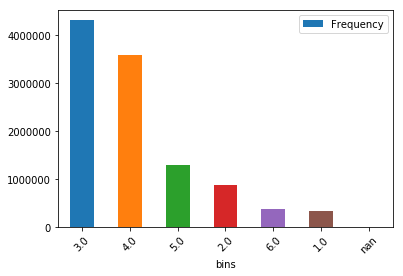

In [43]:
# Visual representation of 'bins' vs 'Frequency':
plt.clf()
plot1 = bin_plot.toPandas()
plot1.plot(x='bins', y='Frequency', kind='bar', rot=45)

In [44]:
# Three most commonly occurring violations for bin 1:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 1 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|            21|          77460|
|            40|          50947|
|            78|          32243|
+--------------+---------------+
only showing top 3 rows



In [45]:
# Three most commonly occurring violations for bin 2:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 2 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|            14|         141276|
|            21|         119469|
|            40|         112186|
+--------------+---------------+
only showing top 3 rows



In [46]:
# Three most commonly occurring violations for bin 3:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 3 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|            21|        1182689|
|            36|         751422|
|            38|         346518|
+--------------+---------------+
only showing top 3 rows



In [47]:
# Three most commonly occurring violations for bin 4:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 4 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|            36|         588395|
|            38|         462758|
|            37|         337075|
+--------------+---------------+
only showing top 3 rows



In [48]:
# Three most commonly occurring violations for bin 5:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 5 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|            38|         203232|
|            37|         145784|
|            14|         144749|
+--------------+---------------+
only showing top 3 rows



In [49]:
# Three most commonly occurring violations for bin 6:

spark.sql("select `Violation Code`,count(*) as Violation_count from binTable where bins == 6 group by `Violation Code` order by Violation_count  desc").show(3)

+--------------+---------------+
|Violation Code|Violation_count|
+--------------+---------------+
|             7|          65593|
|            38|          47029|
|            14|          44779|
+--------------+---------------+
only showing top 3 rows



In [50]:
# Top three bins (time slots) with highest frequency of tickets:

spark.sql("Select bins , count(*) as frequency from binTable group by bins order by frequency desc").show(3)

+----+---------+
|bins|frequency|
+----+---------+
|   3|  4306133|
|   4|  3591755|
|   5|  1296362|
+----+---------+
only showing top 3 rows



#### From Violation code analysis, we have seen that 21,36,38 are the most common violation codes.

In [51]:
# The most common time of the day for three most commonly occurring violation codes:

spark.sql("select bins, count(*) as frequency from binTable where `Violation Code` in (21,36,38) group by bins order by frequency desc").show(3)

+----+---------+
|bins|frequency|
+----+---------+
|   3|  2280629|
|   4|  1199166|
|   5|   230641|
+----+---------+
only showing top 3 rows



##### From this we can conclude that 8 AM - 12 PM (Bin 3), 12 PM - 4 PM (Bin 4) and 4 PM - 8 PM (Bin 5) are the times of the day when most commonly occuring violation codes happen. In short, morning 8 to evening 8 is the time (Working hours of people). 

#### Q.6) Let’s try and find some seasonality in this data:

First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season. 

Then, find the three most common violations for each of these seasons.


In [52]:
# Check 'Issue Date' from the data:

spark.sql("select `Issue Date` from binTable ").show()

+----------+
|Issue Date|
+----------+
|2016-07-10|
|2016-07-08|
|2016-08-23|
|2017-06-14|
|2016-11-21|
|2017-06-13|
|2016-08-03|
|2016-12-21|
|2016-11-21|
|2016-10-05|
|2017-01-11|
|2016-09-27|
|2016-10-27|
|2016-09-30|
|2017-02-04|
|2016-07-07|
|2016-09-24|
|2017-01-26|
|2017-04-30|
|2017-02-03|
+----------+
only showing top 20 rows



In [53]:
# Creating seasons and assigning tickets to each season:

seasons=spark.sql("Select * ,case when month(`Issue Date`) between 3 and 5 then 'Spring' when month(`Issue Date`) between 6 and 8 then 'Summer'  when month(`Issue Date`) between 9 and 11 then 'Autumn' when month(`Issue Date`) in (1,2,12) then 'Winter' else 'none' end as season from binTable")

In [54]:
# Checking seasons:

seasons.show()

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+----+------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|bins|season|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+----+------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|   1|Summer|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|   5|Summer|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|   4|Summer|
|    8478629828|

In [55]:
# Registering seasons as table for SQL queries:

seasons.registerTempTable("seasonTable")

In [56]:
# Frequencies of tickets for each season:

spark.sql("Select season, count(*) as Frequency from seasonTable group by season order by Frequency desc").show()

+------+---------+
|season|Frequency|
+------+---------+
|Spring|  2880687|
|Autumn|  2830802|
|Summer|  2606208|
|Winter|  2485331|
+------+---------+



In [57]:
season_plot = spark.sql("Select season, count(*) as Frequency from seasonTable group by season order by Frequency desc")

<Figure size 432x288 with 0 Axes>

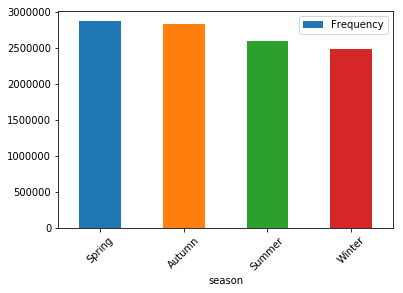

In [58]:
# Visual representation of 'season' vs 'Frequency':

plt.clf()
plot2 = season_plot.toPandas()
plot2.plot(x='season', y='Frequency', kind='bar', rot=45)

In [59]:
# The three most common violations for 'Spring':

spark.sql("Select `Violation Code`, count(*) as Frequency from seasonTable where season ='Spring' group by `Violation Code` order by Frequency desc " ).show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   402807|
|            36|   344834|
|            38|   271192|
+--------------+---------+
only showing top 3 rows



In [60]:
# The three most common violations for 'Summer':

spark.sql("Select `Violation Code`, count(*) as Frequency from seasonTable where season='Summer' group by `Violation Code` order by Frequency desc " ).show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   405961|
|            38|   247561|
|            36|   240396|
+--------------+---------+
only showing top 3 rows



In [61]:
# The three most common violations for 'Winter':

spark.sql("Select `Violation Code`, count(*) as Frequency from seasonTable where season='Winter' group by `Violation Code` order by Frequency desc " ).show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            21|   362341|
|            36|   359338|
|            38|   259723|
+--------------+---------+
only showing top 3 rows



In [62]:
# The three most common violations for 'Autumn':

spark.sql("Select `Violation Code`, count(*) as Frequency from seasonTable where season='Autumn' group by `Violation Code` order by Frequency desc " ).show(3)

+--------------+---------+
|Violation Code|Frequency|
+--------------+---------+
|            36|   456046|
|            21|   357479|
|            38|   283828|
+--------------+---------+
only showing top 3 rows



##### If we look at Season wise analysis, we can see maximum violations during Spring closely followed by Autumn.
##### Three most common violations for each of these seasons are: 21, 36 and 38.

#### Q.7) The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:
Find the total occurrences of the three most common violation codes.
Then, visit the website:
http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.
Using this information, find the total amount collected for the three violation codes with the maximum tickets. State the code that has the highest total collection.

From Violation code analysis, we have seen that 21,36,38 are the most common violation codes. We can verify that from below:

In [63]:
# The total occurrences of the three most common violation codes:

Vio_Codes = spark.sql("Select `Violation Code` as Violation_Code, count(*) as frequency from seasonTable group by `Violation Code` order by frequency desc limit 3" )

In [64]:
# Vio_codes dataframe:

Vio_Codes.collect()

[Row(Violation_Code='21', frequency=1528588),
 Row(Violation_Code='36', frequency=1400614),
 Row(Violation_Code='38', frequency=1062304)]

From the link mentioned in the problem statement, we have found the fines for top three violation codes. 

    Violation code    Manhattan Fine     Other Areas Fine

      21                  65                     45
      36                  50                     50
      38                  65                     35

In [65]:
# Creating a dataframe for violation fines per violation codes:

Vio_Fines1 = Row(Manhattan_Fine = 65, Other_Areas_Fine = 45, Violation_Code = 21) 
Vio_Fines2 = Row(Manhattan_Fine = 50, Other_Areas_Fine = 50, Violation_Code = 36) 
Vio_Fines3 = Row(Manhattan_Fine = 65, Other_Areas_Fine = 35, Violation_Code = 38) 

In [66]:
# Dataframe 'Fines' of both types of fines:

Fines = [Vio_Fines1, Vio_Fines2, Vio_Fines3]
Vio_Fines = spark.createDataFrame(Fines)
display(Vio_Fines)

DataFrame[Manhattan_Fine: bigint, Other_Areas_Fine: bigint, Violation_Code: bigint]

In [67]:
# Combined dataframe of Violation_Codes and Violation_Fines

Final_Fines = Vio_Codes.join(Vio_Fines, "Violation_Code", "inner")
Final_Fines.show()

+--------------+---------+--------------+----------------+
|Violation_Code|frequency|Manhattan_Fine|Other_Areas_Fine|
+--------------+---------+--------------+----------------+
|            21|  1528588|            65|              45|
|            36|  1400614|            50|              50|
|            38|  1062304|            65|              35|
+--------------+---------+--------------+----------------+



In [68]:
# New df with 'Avg_Fine' calculated:

new_df = Final_Fines.withColumn('Avg_Fine', (Final_Fines.Manhattan_Fine + Final_Fines.Other_Areas_Fine)/2)
new_df.show()

+--------------+---------+--------------+----------------+--------+
|Violation_Code|frequency|Manhattan_Fine|Other_Areas_Fine|Avg_Fine|
+--------------+---------+--------------+----------------+--------+
|            21|  1528588|            65|              45|    55.0|
|            36|  1400614|            50|              50|    50.0|
|            38|  1062304|            65|              35|    50.0|
+--------------+---------+--------------+----------------+--------+



In [69]:
# df with Total_Fine calculated:

Total_Fine = new_df.withColumn('Total_Fine', (new_df.frequency * new_df.Avg_Fine))
Total_Fine.show()

+--------------+---------+--------------+----------------+--------+----------+
|Violation_Code|frequency|Manhattan_Fine|Other_Areas_Fine|Avg_Fine|Total_Fine|
+--------------+---------+--------------+----------------+--------+----------+
|            21|  1528588|            65|              45|    55.0|8.407234E7|
|            36|  1400614|            50|              50|    50.0| 7.00307E7|
|            38|  1062304|            65|              35|    50.0| 5.31152E7|
+--------------+---------+--------------+----------------+--------+----------+



<Figure size 432x288 with 0 Axes>

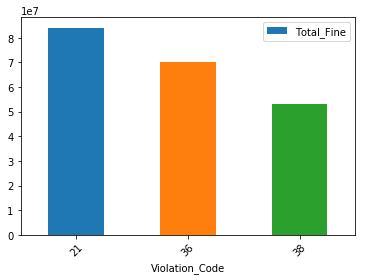

In [70]:
# Visual representation of 'Total_Fine' vs 'Violation_Code':
plt.clf()
plot3 = Total_Fine.toPandas()
plot3.plot(x='Violation_Code', y='Total_Fine', kind='bar', rot=45)

##### Violation Code: 21 has collected the maximum fine. This is true considering the fact that  maximum tickets are of Code:21 (as compared to other two) and the average fine for this is more than other codes too.  

In [72]:
# Total fine collected for top three Violation Codes:

Total_Fine.agg({'Total_Fine': 'sum'}).show()

+---------------+
|sum(Total_Fine)|
+---------------+
|    2.0721824E8|
+---------------+



##### Total fine collected for top three Violation Codes (21,36,38) is: $207218240.


In [ ]:
# Stopping Spark:

spark.stop()

From the entire analysis, we can infer certain things:

    -- We have been supplied with data of 66 states. 
    -- 21, 36 and 38 are most commonly occuring Violation Codes.
    -- Sedans, suburban vehicles, delivery vans are most frequently fined types of vehicles. 
    -- 8 AM to 8 PM (most common working time of maximum people in the city) is the time when maximum tickets have been issued, from which we can infer that may be due to the space crunch for parking during working hours results to maximum violations there by resulting in maxmimum tickets issued.
    -- Season wise analysis tells us that we see maximum violations during Spring closely followed by Autumn. 
    -- If we look at fines collected, we can see that maximum fine is collected for Violation Code 21 and Total fine collected for top three Violation Codes (21,36,38) is: $207218240.